<a href="https://colab.research.google.com/github/noahkarsky/Geoscience_Disciplines/blob/master/Geologic_branches_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the first notebook we were able to create a dataset that contains the content for each discipline pulled from wikipedia. Now we will use that data to:

1. Get counts of all the words in each and create a sparsematrix representation using the countvectorizer method from sklearn
2. Reduce the dimensions from all the disciplines into two. We do this both to see where the data plot in relation to eachother, but also to make a sweet visualization
3. Clusters will then be grouped using HDBSCAN algorithm 

In [ ]:
pip install umap-learn[plot]

In [2]:
pip install hdbscan

     |████████████████████████████████| 4.7MB 2.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2301843 sha256=8607467cc12e4efd392e280c535cc537106830a34829bc32275e0ea9494615ee
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan


In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import umap
import umap.plot
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [5]:
df = pd.read_csv(r"https://raw.githubusercontent.com/noahkarsky/Geoscience_Disciplines/master/Parsed_wiki_data.csv", names=["index","related_word","discipline"],skiprows=[0])

In [8]:
#this will make each discipline into a row and the new column will be called the article_text
df1 = df.groupby('discipline')['related_word'].apply(list).reset_index(name='article_text')
df1['text'] = df1.article_text.astype(str).str.replace('\[|\]|\'', '').str.replace(',','')

In [9]:
df1.head()

,discipline,article_text,text
0,Agricultural Meteorology,"[Meteorology, branch, atmospheric, sciences, i...",Meteorology branch atmospheric sciences includ...
1,Applied Climatology,"[Climatology, (from, Greek, κλίμα,, klima,, ""p...","Climatology (from Greek κλίμα klima ""place zon..."
2,Applied geomorphology,"[The, Chambal, geographical, cultural, region,...",The Chambal geographical cultural region north...
3,Archaeological Palynology,"[Palynology, literally, ""study, dust"", (from, ...","Palynology literally ""study dust"" (from Greek:..."
4,Asteroseismology,"[Asteroseismology, study, oscillations, stars....",Asteroseismology study oscillations stars. nan...


In [10]:

vectorizer = CountVectorizer(min_df=5, stop_words='english') #pretty sure I am double applying stopwords here....oh well now we know FOR SURE there are no stop words gunking up the workflow
word_doc_matrix = vectorizer.fit_transform(df1.text)

In [11]:
mapper = umap.UMAP(n_neighbors=10, metric='cosine', min_dist=0.1, random_state=42).fit_transform(word_doc_matrix)
embedding = pd.DataFrame(mapper, columns = ['x','y'])
#the embedding is the output of the UMAP algorithm, so we will rejoin the discipline names for viewing in the interactive plot below
bedding['title'] = df1.discipline

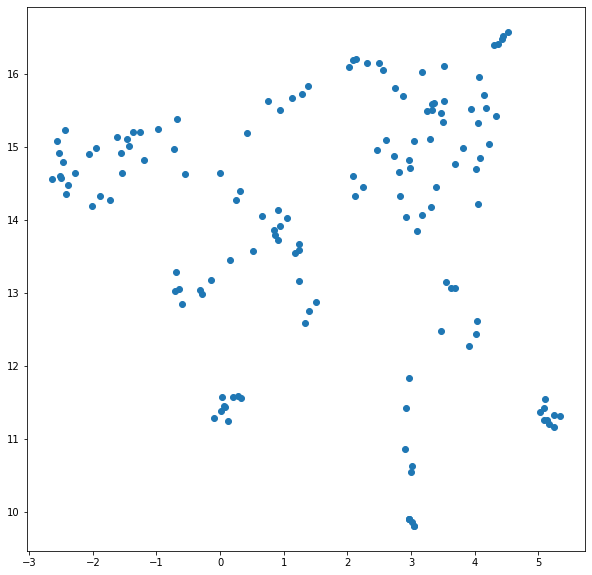

In [21]:
fig, ax = plt.subplots(figsize = (10,10))
plt.scatter(embedding['x'], embedding['y'],)

Visually we can see clusters of data, but lets take a look at what HDBSCAN finds and distinguishes as outliers within this 2D mapping of the data

In [14]:

clusterer = hdbscan.HDBSCAN()
clusterer.fit(mapper)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

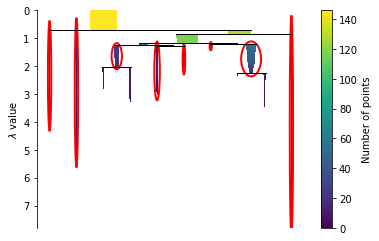

In [20]:
clusterer.condensed_tree_.plot(select_clusters=True)

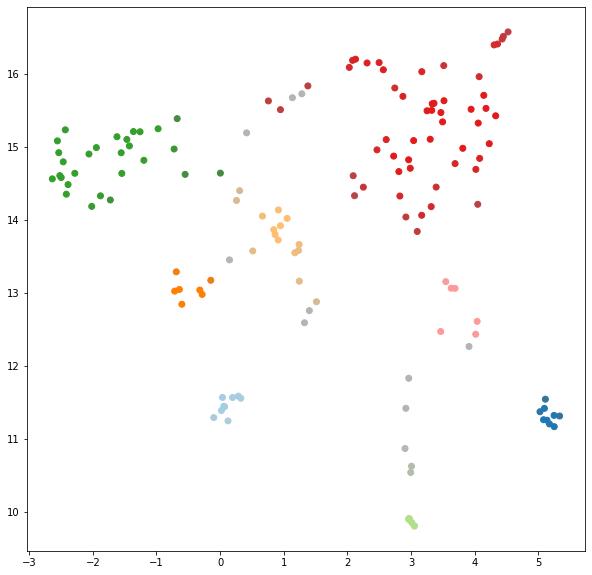

In [17]:
#these two lines allow us to desaturate the color of points based on their probabilities of being within a cluster.
pal = sns.color_palette('Paired', 87)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_,clusterer.probabilities_)]


fig, ax = plt.subplots(figsize = (10,10))
plt.scatter(embedding['x'], embedding['y'], c=colors,)

In [18]:
fig = px.scatter(embedding,x='x',y='y',color=clusterer.labels_,hover_data=['title'],width=800, height=800)
fig.show()

Beautiful :')